### Outline:

Some EDA

Data Preprocessing: Column Transformer

Model Building: Pipeline

Model selection: Grid Search CV

Save model: Joblib

Make predictions on an unseen data point

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline    
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
%run app.py
import requests




 * Serving Flask app 'app'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

In [3]:
# print("Mark 1:", mark1)
# print("Mark 2:", mark2)

df = pd.read_csv('Mydata.csv')
df.head()

,S.NO.,first_name,last_name,email,gender,First Year Marks,Second Year Marks,Third Year Marks,Course,Language,Country,Parental Education
0,1,Anatola,Mathewson,amathewson0@1und1.de,Genderfluid,94,61,75,Product Management,Somali,Russia,False
1,2,Fanni,Adran,fadran1@xinhuanet.com,Female,76,87,92,Human Resources,Macedonian,Russia,False
2,3,Dick,Claisse,dclaisse2@php.net,Male,70,100,87,Human Resources,Māori,Russia,False
3,4,Yoshi,Lowfill,ylowfill3@usda.gov,Female,73,98,77,Sales,Spanish,Russia,False
4,5,Romy,Reisenberg,rreisenberg4@mit.edu,Female,86,58,91,Engineering,Tetum,Russia,False


In [4]:
df.shape

(1000, 12)

In [5]:
scores = df.columns[df.columns.str.contains('Marks')].tolist()
scores

['First Year Marks', 'Second Year Marks', 'Third Year Marks']

##### EDA:

histograms:

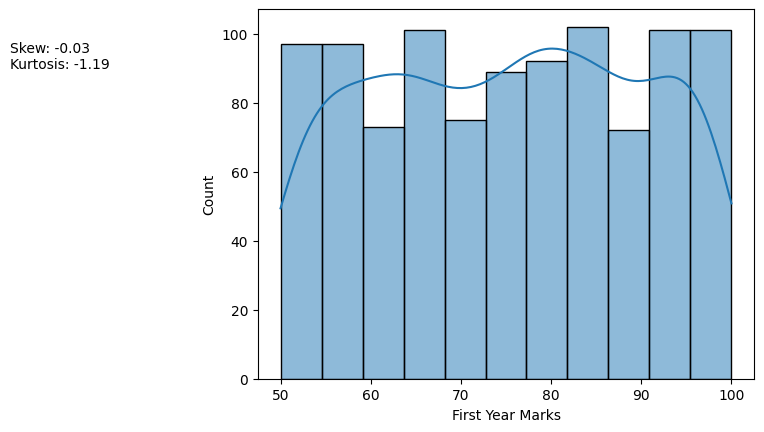

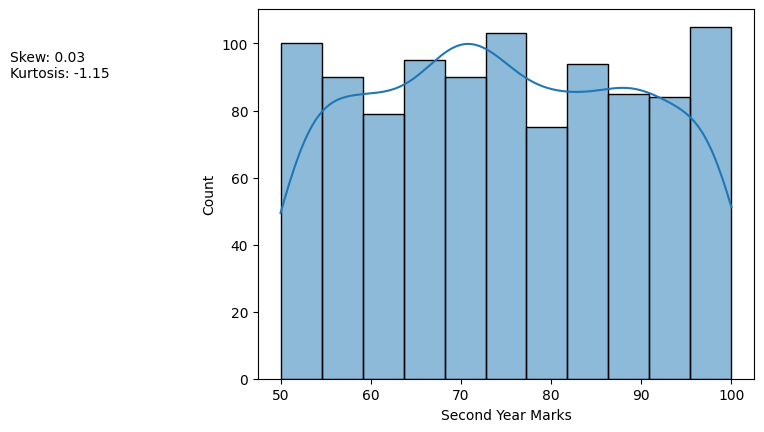

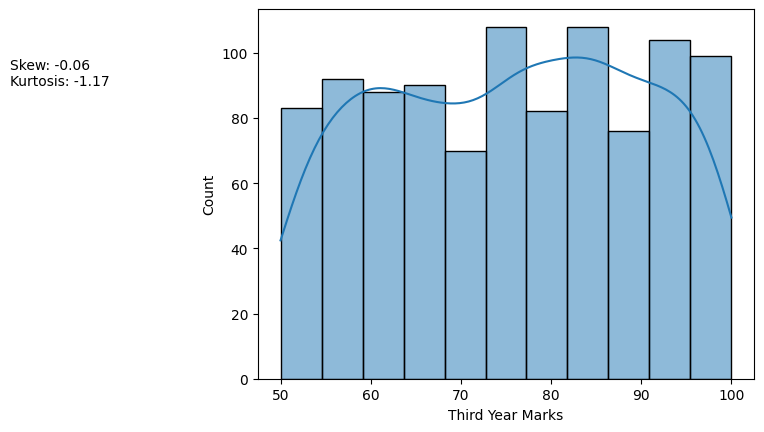

In [6]:
for Marks in scores:
    sns.histplot(df[Marks], element='bars', kde=True)
    plt.text(x=20, y=90, s=f"Skew: {round(df[Marks].skew(),2)}\nKurtosis: {round(df[Marks].kurt(),2)}")
    plt.show()

In [7]:
df.describe()

,S.NO.,First Year Marks,Second Year Marks,Third Year Marks
count,1000.000000,1000.000000,1000.000000,1000.00000
mean,500.500000,75.229000,74.935000,75.63500
std,288.819436,14.752837,14.645179,14.44737
min,1.000000,50.000000,50.000000,50.00000
25%,250.750000,62.000000,62.000000,63.00000
50%,500.500000,76.000000,74.000000,76.00000
75%,750.250000,87.250000,88.000000,88.00000
max,1000.000000,100.000000,100.000000,100.00000


pairplot:

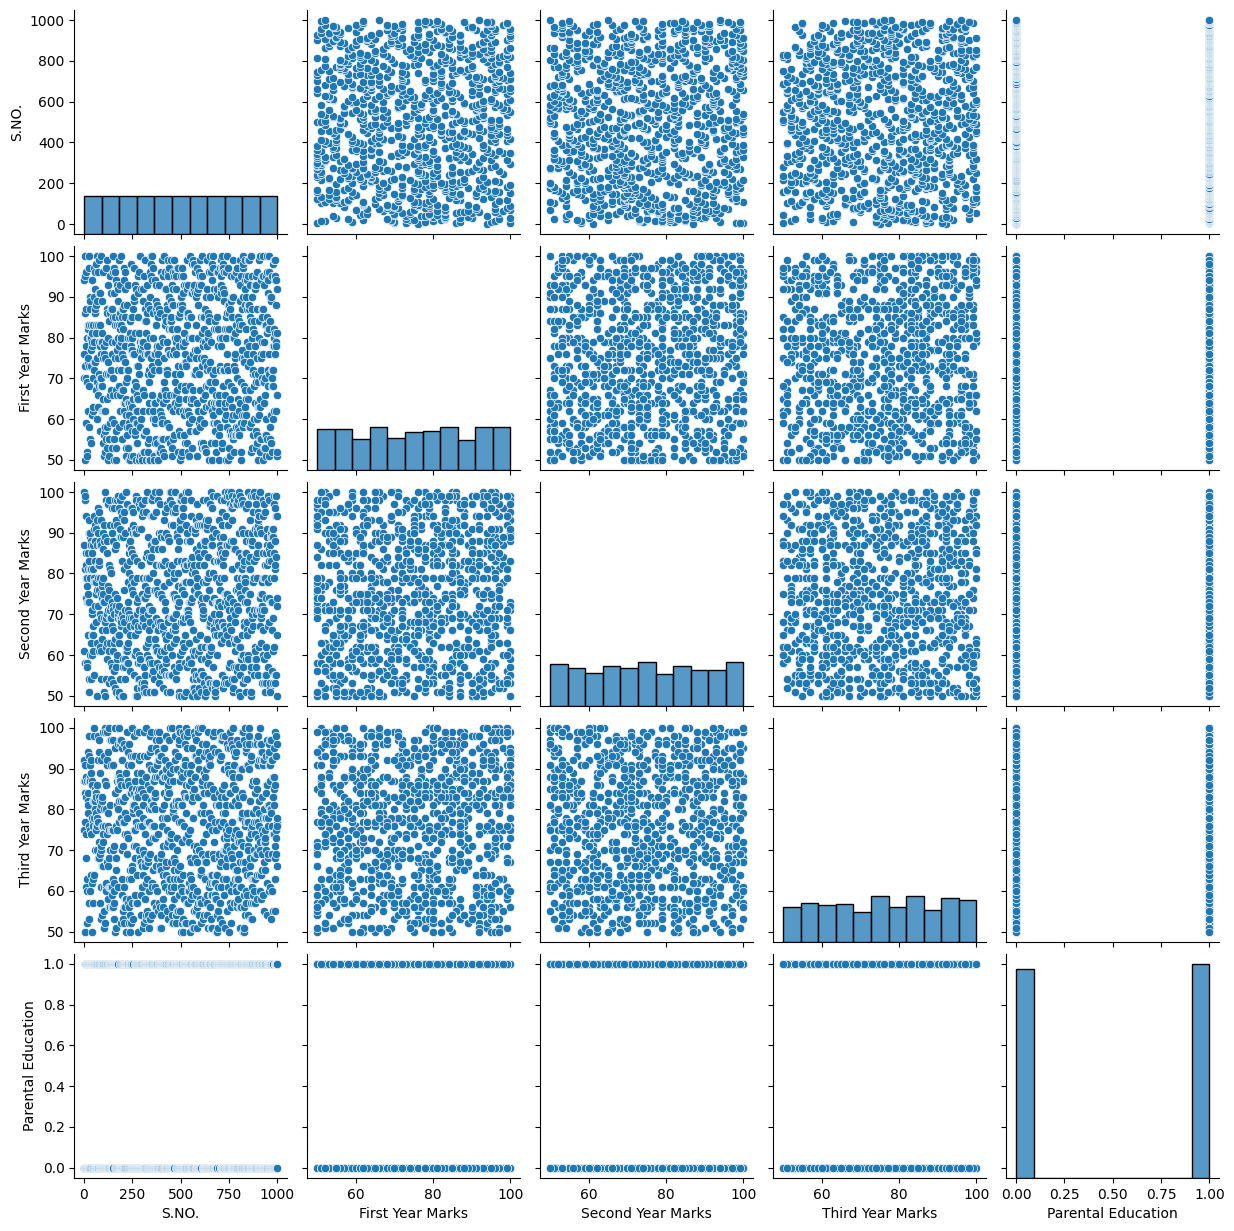

In [8]:
sns.pairplot(data=df)

scores vs lunch type:

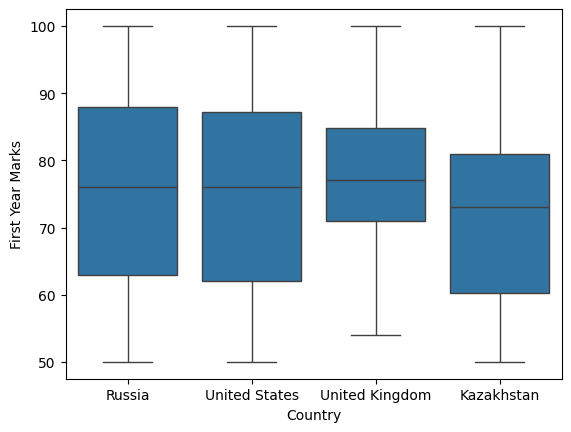

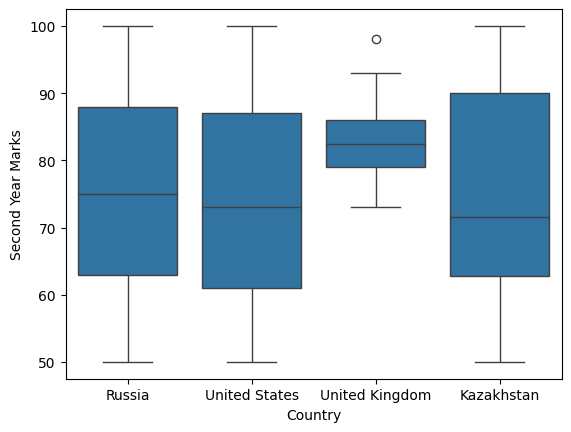

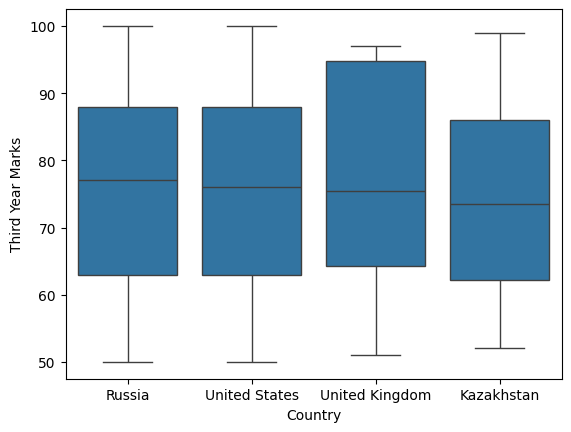

In [9]:
for score in scores:
    sns.boxplot(y=df[score], x=df['Country'])
    plt.show()

scores vs race/ ethnicity group:

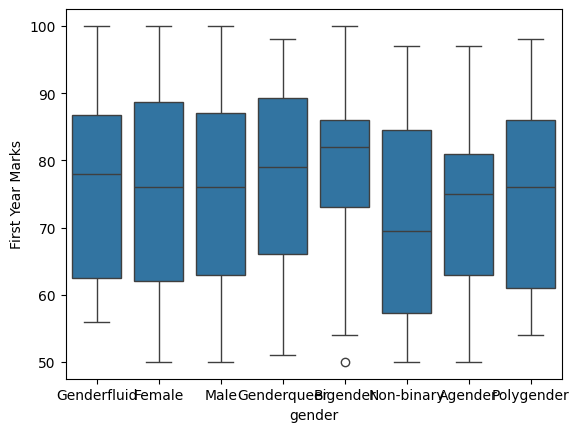

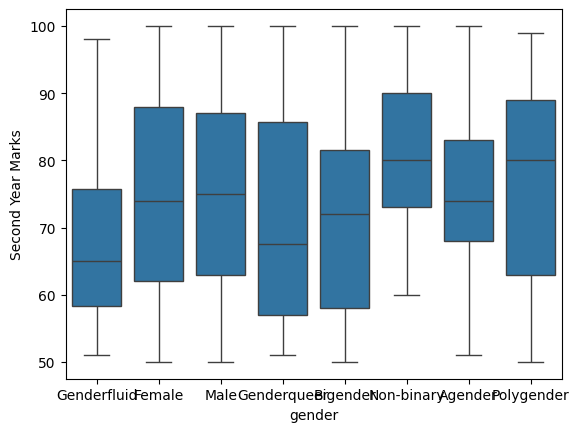

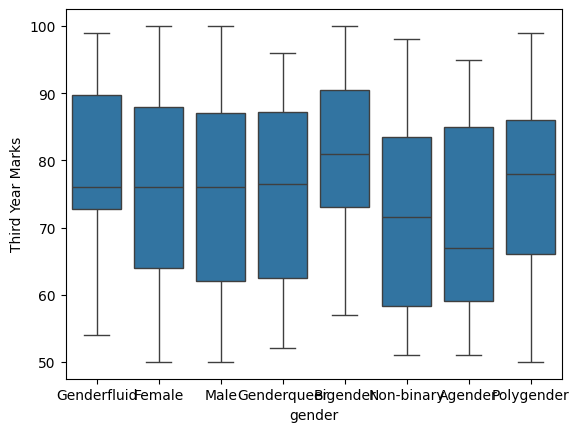

In [10]:
for score in scores:
    sns.boxplot(y=df[score], x=df['gender'])
    plt.show()

scores vs whether completed the test prep course:

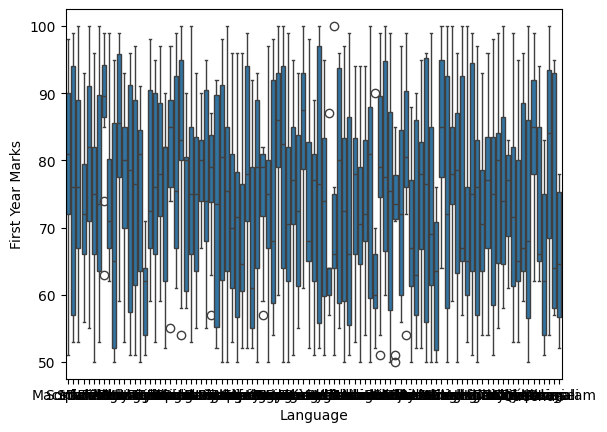

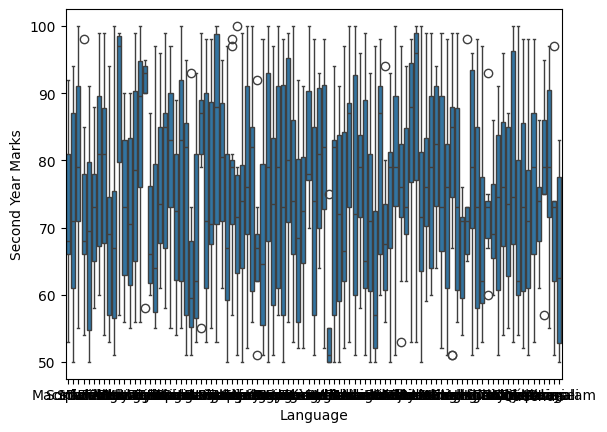

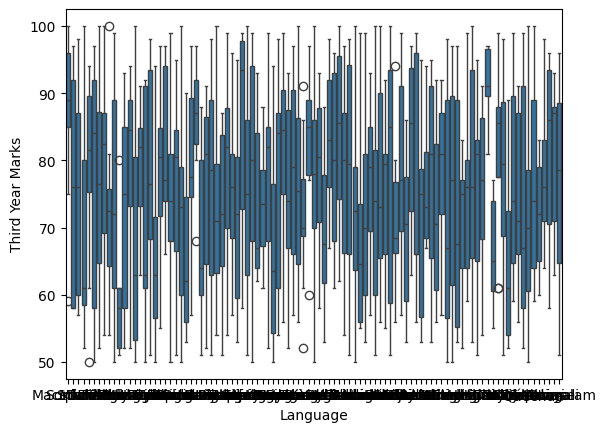

In [11]:
for score in scores:
    sns.boxplot(y=df[score], x=df['Language'])
    plt.show()

scores vs parental education level:

In [12]:
X, y = df.drop('Third Year Marks', axis=1), df['Third Year Marks']

In [13]:
cat_cols = X.dtypes[X.dtypes == 'O'].index.tolist()
cat_cols

['first_name', 'last_name', 'email', 'gender', 'Course', 'Language', 'Country']

In [14]:
ct = ColumnTransformer([
    ('num', StandardScaler(), ['First Year Marks', 'Second Year Marks']),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [15]:
ct.fit_transform(X).shape

(1000, 3059)

In [16]:
pipe = Pipeline([
    ('trf', ct),
    ('model', LGBMRegressor(random_state=0))
])

In [17]:
params = {
    'model__n_estimators':[100,130,150,170,190],
    'model__boosting_type': ['dart', 'gbdt', 'goss']
}

In [18]:
gs = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [19]:
gs.fit(X, y)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 24
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 75.635000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

GridSearchCV(estimator=Pipeline(steps=[('trf',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['First '
                                                                          'Year '
                                                                          'Marks',
                                                                          'Second '
                                                                          'Year '
                                                                          'Marks']),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['first_name',
                                                                          'last_name',
                                                                          'email',
                                                                          'gender',
                                                                          'Course',
                                                                          'Language',
                                                                          'Country'])])),
                                       ('model',
                                        LGBMRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__boosting_type': ['dart', 'gbdt', 'goss'],
                         'model__n_estimators': [100, 130, 150, 170, 190]},
             scoring='neg_root_mean_squared_error')

In [20]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__boosting_type,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,1.353552,0.113714,0.092974,0.005419,goss,130,"{'model__boosting_type': 'goss', 'model__n_est...",-18.387923,-15.500277,-15.571618,-15.100485,-14.625236,-15.837108,1.319230,1
5,1.348138,0.124720,0.088620,0.003832,gbdt,100,"{'model__boosting_type': 'gbdt', 'model__n_est...",-16.497312,-16.067205,-16.830182,-15.524862,-14.430108,-15.869934,0.842231,2
10,0.957903,0.175254,0.098272,0.006277,goss,100,"{'model__boosting_type': 'goss', 'model__n_est...",-19.295662,-15.606299,-15.480357,-14.873972,-14.491886,-15.949635,1.721399,3
12,1.462729,0.125657,0.093360,0.003972,goss,150,"{'model__boosting_type': 'goss', 'model__n_est...",-18.761998,-15.710987,-15.743005,-15.098894,-14.503175,-15.963612,1.471330,4
4,2.133415,0.155462,0.091898,0.003938,dart,190,"{'model__boosting_type': 'dart', 'model__n_est...",-17.786177,-15.518876,-16.445425,-15.064158,-15.195442,-16.002015,1.014239,5
6,1.680551,0.115788,0.093781,0.007329,gbdt,130,"{'model__boosting_type': 'gbdt', 'model__n_est...",-16.897283,-16.056747,-17.019326,-15.650827,-14.570812,-16.038999,0.894903,6
7,1.766732,0.023767,0.089801,0.001882,gbdt,150,"{'model__boosting_type': 'gbdt', 'model__n_est...",-16.876495,-16.140287,-17.064887,-15.784077,-14.572936,-16.087736,0.890680,7
13,1.501590,0.068365,0.093109,0.004376,goss,170,"{'model__boosting_type': 'goss', 'model__n_est...",-19.767881,-15.622804,-15.708281,-15.085614,-14.541021,-16.145120,1.859233,8
8,1.830400,0.042436,0.090896,0.005712,gbdt,170,"{'model__boosting_type': 'gbdt', 'model__n_est...",-16.957078,-16.171159,-17.151428,-15.848348,-14.620676,-16.149738,0.903826,9
9,2.416789,0.395988,0.093701,0.005925,gbdt,190,"{'model__boosting_type': 'gbdt', 'model__n_est...",-17.143665,-16.212754,-17.273849,-15.909218,-14.611918,-16.230281,0.963929,10


In [21]:
gs.best_params_

{'model__boosting_type': 'goss', 'model__n_estimators': 130}

In [22]:
gs.best_score_

-15.83710800105302

In [23]:
gs.best_estimator_

Pipeline(steps=[('trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['First Year Marks',
                                                   'Second Year Marks']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['first_name', 'last_name',
                                                   'email', 'gender', 'Course',
                                                   'Language', 'Country'])])),
                ('model',
                 LGBMRegressor(boosting_type='goss', n_estimators=130,
                               random_state=0))])

In [24]:
joblib.dump(gs.best_estimator_, 'model.joblib')

['model.joblib']

##### importing the model:

In [25]:
mdl = joblib.load('model.joblib')

##### Making predictions on a new data point NOT seen by the model

In [28]:

# m1 = "78"
# m2 = "90"


# q = pd.DataFrame([[3 , 'snagram' , 'patnaik' , 'sangramp@.net' , 'Male' , m1 , m2 , 'Engineering' , 'indian' , 'India' , True]],
#              columns=X.columns)
# q


import requests

# Define the Flask server URL
flask_url = 'http://localhost:5000'  # Replace with your Flask server URL if different

# Function to retrieve data from Flask
def retrieve_marks():
    try:
        response = requests.get(f'{flask_url}/get_marks')
        if response.status_code == 200:
            data = response.json()
            mark1 = data['mark1']
            mark2 = data['mark2']
            return mark1, mark2
        else:
            print("Failed to retrieve marks from Flask server")
            return None, None
    except Exception as e:
        print("An error occurred:", e)
        return None, None

# Retrieve marks from Flask
m1, m2 = retrieve_marks()

# Print the retrieved marks
print("Mark 1:", m1)
print("Mark 2:", m2)

q = pd.DataFrame([[3 , 'sangram' , 'patnaik' , 'sangramp@.net' , 'Male' , m1 , m2 , 'Engineering' , 'indian' , 'India' , True]],
              columns=X.columns)
q

Mark 1: 70
Mark 2: 90


,S.NO.,first_name,last_name,email,gender,First Year Marks,Second Year Marks,Course,Language,Country,Parental Education
0,3,sangram,patnaik,sangramp@.net,Male,70,90,Engineering,indian,India,True


In [29]:
mdl.predict(q)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


array([75.63200232])